In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
import pickle


In [40]:
movies = pd.read_csv('../data/movies_dataset.csv')

In [41]:
movies.head(1)

,budget,id,original_language,revenue,runtime,title,vote_average,vote_count,top_cast,director,genres,keywords,release_year,profit,decade
0,30000000.0,862,en,373554033.0,81.0,Toy Story,7.7,5415.0,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",John Lasseter,"['Animation', 'Comedy', 'Family']","['jealousy', 'toy', 'boy', 'friendship', 'frie...",1995,343554033.0,1990


In [42]:
# Checking if genres, top_cast, and keywords are all the same type
print("genres:")
print(type(movies.loc[0, 'genres']))
print(movies.loc[0, 'genres'])
print(type(movies.loc[0, 'genres'][0]))

print("\ntop_cast:")
print(type(movies.loc[0, 'top_cast']))
print(movies.loc[0, 'top_cast'])
print(type(movies.loc[0, 'top_cast'][0]))

print("\nkeywords:")
print(type(movies.loc[0, 'keywords']))
print(movies.loc[0, 'keywords'])
print(type(movies.loc[0, 'keywords'][0]))

genres:
<class 'str'>
['Animation', 'Comedy', 'Family']
<class 'str'>

top_cast:
<class 'str'>
['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney', 'Wallace Shawn']
<class 'str'>

keywords:
<class 'str'>
['jealousy', 'toy', 'boy', 'friendship', 'friends', 'rivalry', 'boy next door', 'new toy', 'toy comes to life']
<class 'str'>


In [43]:
# Convert columns from string to list
for col in ['genres', 'top_cast', 'keywords']:
    movies[col] = movies[col].apply(ast.literal_eval)

### For ML I need to encode my qualitive features, and scale my quantitative features

In [44]:
# Limiting features before encoding
# Keywords - limiting to 200 
all_keywords = pd.Series([kw for kws in movies['keywords'] for kw in kws])
top_keywords = all_keywords.value_counts().head(100).index
movies['keywords'] = movies['keywords'].apply(lambda kws: [kw for kw in kws if kw in top_keywords])

# Actors - limiting to 200
all_actors = pd.Series([actor for cast in movies['top_cast'] for actor in cast])
top_actors = all_actors.value_counts().head(100).index
movies['top_cast'] = movies['top_cast'].apply(lambda cast: [actor for actor in cast if actor in top_actors])

# Directors - limiting to 200
top_directors = movies['director'].value_counts().head(50).index
movies['director'] = movies['director'].apply(lambda d: d if d in top_directors else 'Other')

# I will be skipping genres as they are already limited



In [45]:
# Encoding features
# Genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(movies['genres'])

# Keywords
mlb_keywords = MultiLabelBinarizer()
keywords_encoded = mlb_keywords.fit_transform(movies['keywords'])

# Top Cast
mlb_cast = MultiLabelBinarizer()
cast_encoded = mlb_cast.fit_transform(movies['top_cast'])

# Director (one-hot)
director_encoded = pd.get_dummies(movies['director']).values

# Language (one-hot)
language_encoded = pd.get_dummies(movies['original_language']).values


In [46]:
# Scaling features using StandardScaler
num_features = ['budget', 'revenue', 'runtime', 'profit', 'vote_average', 'vote_count', 'release_year', 'decade']
scaler = StandardScaler()
num_encoded = scaler.fit_transform(movies[num_features])

In [47]:
X = np.hstack([
    genres_encoded,
    keywords_encoded,
    cast_encoded,
    director_encoded,
    language_encoded,
    num_encoded 
])

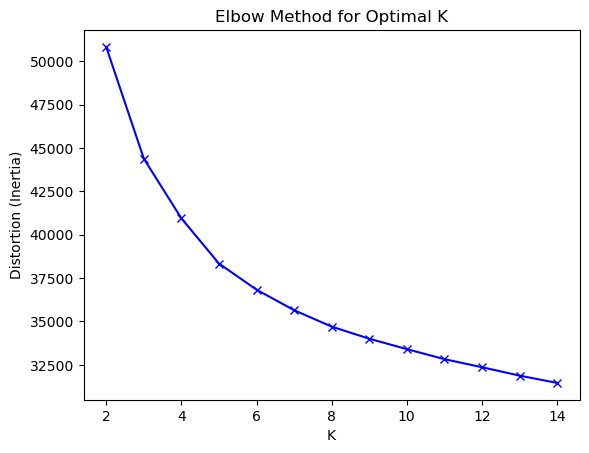

In [54]:
distortions = []
K = range(2, 15)
for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X)
    distortions.append(model.inertia_)  # inertia_ is the sum of squared distances

plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

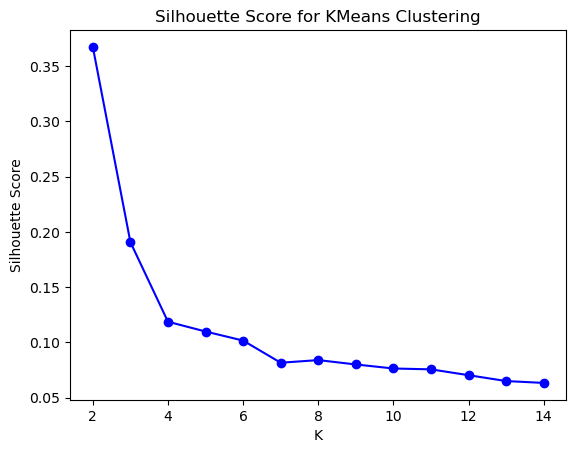

In [55]:
scores = []
for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.figure()
plt.plot(K, scores, 'bo-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans Clustering')
plt.show()

In [72]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, n_init=20, random_state=42)
movies['cluster'] = kmeans.fit_predict(X)

In [73]:
print(movies['cluster'].value_counts().sort_index())


cluster
0     623
1     742
2    1866
3    1560
4     149
Name: count, dtype: int64


In [74]:
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    cluster_movies = movies[movies['cluster'] == i]
    print("Top genres:", pd.Series([g for genres in cluster_movies['genres'] for g in genres]).value_counts().head(5))
    print("Top directors:", cluster_movies['director'].value_counts().head(3))
    print("Top languages:", cluster_movies['original_language'].value_counts().head(3))
    print("Example movies:", cluster_movies['title'].head(3).tolist())




Cluster 0:
Top genres: Action       290
Adventure    228
Comedy       215
Thriller     201
Drama        165
Name: count, dtype: int64
Top directors: director
Other               487
Steven Spielberg     14
Robert Zemeckis      12
Name: count, dtype: int64
Top languages: original_language
en    615
zh      3
fr      2
Name: count, dtype: int64
Example movies: ['Toy Story', 'Jumanji', 'GoldenEye']

Cluster 1:
Top genres: Drama        371
Comedy       197
Thriller     185
Action       168
Adventure    153
Name: count, dtype: int64
Top directors: director
Other               594
Alfred Hitchcock     21
Billy Wilder         11
Name: count, dtype: int64
Top languages: original_language
en    719
fr      8
ja      5
Name: count, dtype: int64
Example movies: ['Taxi Driver', 'Blade Runner', 'Snow White and the Seven Dwarfs']

Cluster 2:
Top genres: Comedy      914
Thriller    613
Action      520
Drama       509
Horror      371
Name: count, dtype: int64
Top directors: director
Other            

In [75]:
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}: Example Movies")
    display(movies[movies['cluster'] == cluster_id][['title', 'genres', 'director', 'original_language', 'vote_average']].head(5))



Cluster 0: Example Movies


,title,genres,director,original_language,vote_average
0,Toy Story,"[Animation, Comedy, Family]",Other,en,7.7
1,Jumanji,"[Adventure, Fantasy, Family]",Other,en,6.9
4,GoldenEye,"[Adventure, Action, Thriller]",Other,en,6.6
16,Twelve Monkeys,"[Science Fiction, Thriller, Mystery]",Terry Gilliam,en,7.4
22,Se7en,"[Crime, Mystery, Thriller]",Other,en,8.1



Cluster 1: Example Movies


,title,genres,director,original_language,vote_average
40,Taxi Driver,"[Crime, Drama]",Martin Scorsese,en,8.1
188,Blade Runner,"[Science Fiction, Drama, Thriller]",Ridley Scott,en,7.9
204,Snow White and the Seven Dwarfs,"[Fantasy, Animation, Family]",Other,en,6.9
206,Pinocchio,"[Animation, Family]",Other,en,6.9
208,The Wild Bunch,"[Adventure, Western]",Other,en,7.7



Cluster 2: Example Movies


,title,genres,director,original_language,vote_average
3,Sudden Death,"[Action, Adventure, Thriller]",Peter Hyams,en,5.5
6,Cutthroat Island,"[Action, Adventure]",Renny Harlin,en,5.7
8,Four Rooms,"[Crime, Comedy]",Other,en,6.5
9,Ace Ventura: When Nature Calls,"[Crime, Comedy, Adventure]",Other,en,6.1
10,Money Train,"[Action, Comedy, Crime]",Other,en,5.4



Cluster 3: Example Movies


,title,genres,director,original_language,vote_average
2,Waiting to Exhale,"[Comedy, Drama, Romance]",Other,en,6.1
5,The American President,"[Comedy, Drama, Romance]",Rob Reiner,en,6.5
7,Sense and Sensibility,"[Drama, Romance]",Other,en,7.2
12,Assassins,"[Action, Adventure, Crime, Thriller]",Richard Donner,en,6.0
13,Leaving Las Vegas,"[Drama, Romance]",Other,en,7.1



Cluster 4: Example Movies


,title,genres,director,original_language,vote_average
95,Star Wars,"[Adventure, Action, Science Fiction]",Other,en,8.1
125,Forrest Gump,"[Comedy, Drama, Romance]",Robert Zemeckis,en,8.2
128,The Lion King,"[Family, Animation, Drama]",Other,en,8.0
162,Jurassic Park,"[Adventure, Science Fiction]",Steven Spielberg,en,7.6
201,Terminator 2: Judgment Day,"[Action, Thriller, Science Fiction]",Other,en,7.7


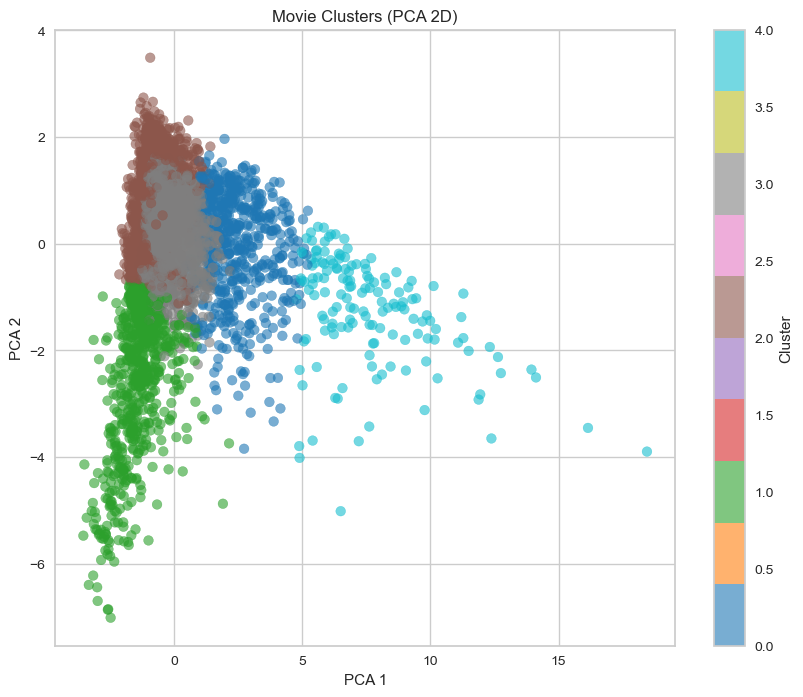

In [76]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=movies['cluster'], cmap='tab10', alpha=0.6)
plt.title('Movie Clusters (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


In [77]:
score = silhouette_score(X, movies['cluster'])
print(f'Silhouette Score for K={optimal_k}: {score:.3f}')

Silhouette Score for K=5: 0.110


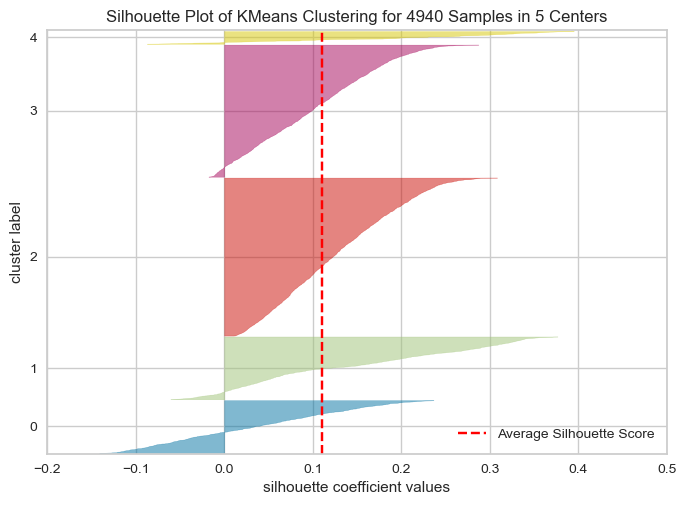

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4940 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [78]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()
